In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Link to the dataset

https://www.kaggle.com/datasets/austinreese/usa-housing-listings

In [98]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
df = pd.read_csv('housing.csv')

In [100]:
df.shape

(384977, 22)

In [101]:
df.head(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca


# 1. Data Cleaning

In [102]:
df.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64

### 1.1 fill null values

In [103]:
df['laundry_options'].fillna('no laundry on site', inplace=True)
df['parking_options'].fillna('no parking', inplace=True)
df['description'].fillna('no description', inplace=True)

In [104]:
df.isnull().sum()

id                            0
url                           0
region                        0
region_url                    0
price                         0
type                          0
sqfeet                        0
beds                          0
baths                         0
cats_allowed                  0
dogs_allowed                  0
smoking_allowed               0
wheelchair_access             0
electric_vehicle_charge       0
comes_furnished               0
laundry_options               0
parking_options               0
image_url                     0
description                   0
lat                        1918
long                       1918
state                         0
dtype: int64

### 1.2 filter out records outside of the USA

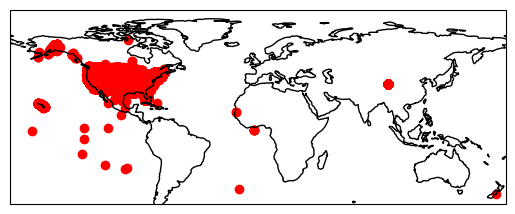

In [105]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()


In [106]:
lat_min_main, lat_max_main = 24.396308, 49.384358
lon_min_main, lon_max_main = -125.0, -66.93457

lat_min_hawaii, lat_max_hawaii = 18.5, 22.5
lon_min_hawaii, lon_max_hawaii = -160, -154

df = df[
    ((df['lat'] >= lat_min_main) & 
     (df['lat'] <= lat_max_main) & 
     (df['long'] >= lon_min_main) & 
     (df['long'] <= lon_max_main)) |
    ((df['lat'] >= lat_min_hawaii) & 
     (df['lat'] <= lat_max_hawaii) & 
     (df['long'] >= lon_min_hawaii) & 
     (df['long'] <= lon_max_hawaii))
]


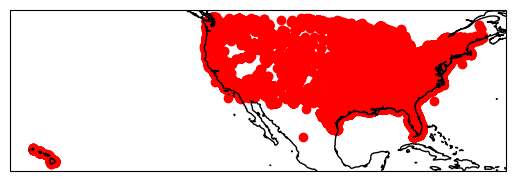

In [107]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()

### 1.3. Drop columns that are meaningless for analysis

In [108]:
df.drop(columns=['url', 'region_url', 'image_url'], inplace=True)

In [109]:
df.isnull().sum()

id                         0
region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
description                0
lat                        0
long                       0
state                      0
dtype: int64

### 1.4. Detect outliers

In [110]:
df['beds'].value_counts().sort_index()

beds
0        10836
1       116120
2       173539
3        66133
4        11394
5         2301
6          238
7           49
8           31
1000         2
1100         2
Name: count, dtype: int64

In [111]:
df = df[df['beds'] < 10]

In [112]:
"""
Fractional Bathroom Values Represent
Whole Numbers (e.g., 1.0, 2.0): Represent the count of full bathrooms.
Fractions (e.g., 1.5, 2.5): Represent a combination of full and half bathrooms:
A full bathroom typically includes a toilet, sink, and shower/tub.
A half bathroom (0.5) includes only a toilet and sink.
"""

df['baths'].value_counts() 

baths
1.0    195727
2.0    133499
1.5     27068
2.5     12934
3.0      5419
0.0      3067
4.0      1476
3.5      1003
4.5       223
5.0       130
5.5        57
6.0        26
7.0         4
6.5         4
7.5         2
8.5         1
8.0         1
Name: count, dtype: int64

In [113]:
# 1000 sqft = 92.9 m^2
# 15000 sqft = 1393 m^2

print('sqfeet min:', df['sqfeet'].min()) 
print('sqfeet 25th quantile', df['sqfeet'].quantile(0.25))
print('sqfeet median:', df['sqfeet'].median())
print('sqfeet 75th quantile', df['sqfeet'].quantile(0.75))
print('sqfeet max:', df['sqfeet'].max())

df = df[(df['sqfeet'] > 100) & (df['sqfeet'] < 15000)]

sqfeet min: 0
sqfeet 25th quantile 750.0
sqfeet median: 949.0
sqfeet 75th quantile 1150.0
sqfeet max: 8388607


<Axes: xlabel='sqfeet', ylabel='Density'>

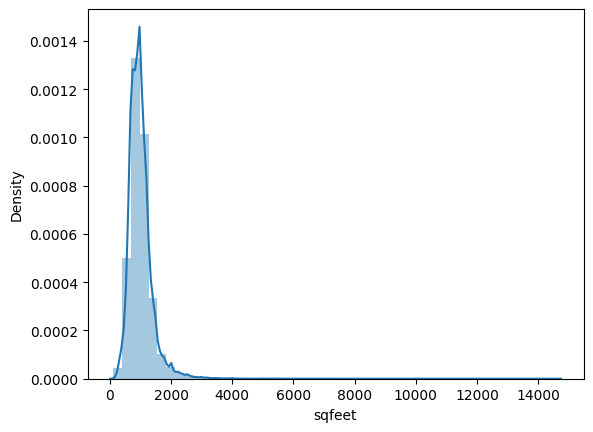

In [114]:
sns.distplot(df['sqfeet'])

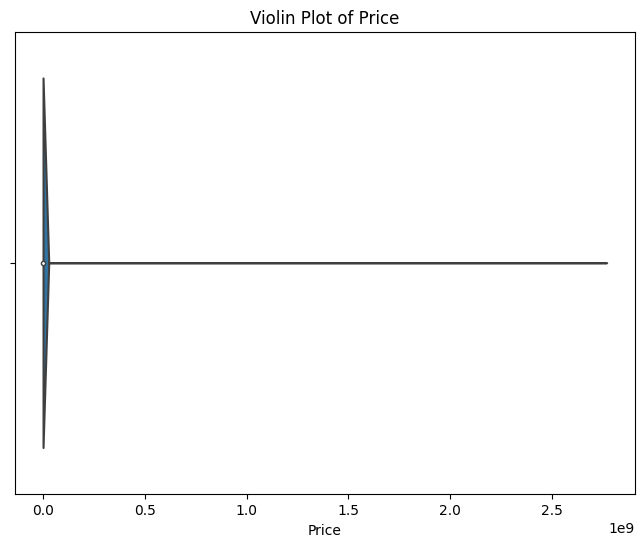

In [115]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['price'], inner='box')
plt.title('Violin Plot of Price')
plt.xlabel('Price')
plt.show()

In [116]:
df['price'].min(), df['price'].max()

(0, 2768307249)

In [117]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print('lower_bound:', lower_bound)
print('median:', df['price'].median())
print('upper_bound:', upper_bound)

quantile_1 = df['price'].quantile(0.01)
quantile_99 = df['price'].quantile(0.99)
print('quantile 1:', df['price'].quantile(0.01))
print('quantile 99:', df['price'].quantile(0.99))

df = df[(df['price'] >= quantile_1) & (df['price'] < quantile_99)]

Q1: 805.0, Q3: 1395.0, IQR: 590.0
lower_bound: -80.0
median: 1036.0
upper_bound: 2280.0
quantile 1: 349.0
quantile 99: 3395.0


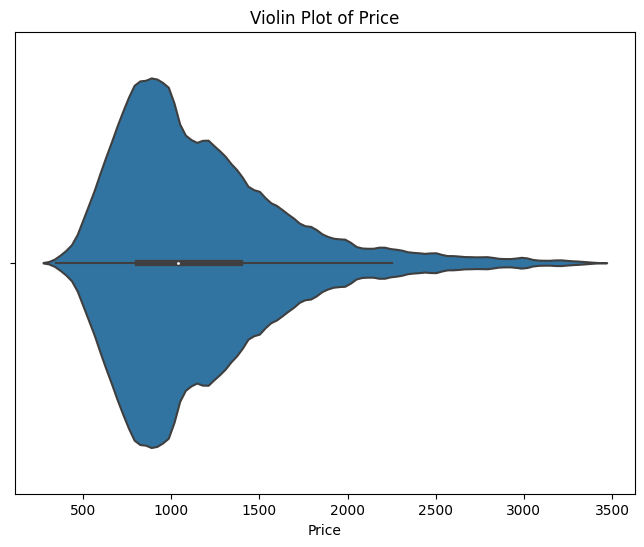

In [118]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['price'], inner='box')
plt.title('Violin Plot of Price')
plt.xlabel('Price')
plt.show()

# 2. Feature Engineering

In [119]:
df['price/sqfeet'] = df['price'] / df['sqfeet']

### Added full names for US states and country parts

In [120]:
state_full_names = {
    'fl': 'Florida', 'ca': 'California', 'tx': 'Texas', 'nc': 'North Carolina', 'mi': 'Michigan', 'ga': 'Georgia',
    'oh': 'Ohio', 'tn': 'Tennessee', 'co': 'Colorado', 'va': 'Virginia', 'sc': 'South Carolina', 'pa': 'Pennsylvania',
    'ny': 'New York', 'il': 'Illinois', 'al': 'Alabama', 'or': 'Oregon', 'ks': 'Kansas', 'md': 'Maryland',
    'ia': 'Iowa', 'mn': 'Minnesota', 'la': 'Louisiana', 'wa': 'Washington', 'az': 'Arizona', 'wi': 'Wisconsin',
    'in': 'Indiana', 'ok': 'Oklahoma', 'nj': 'New Jersey', 'ky': 'Kentucky', 'ut': 'Utah', 'ms': 'Mississippi',
    'ma': 'Massachusetts', 'id': 'Idaho', 'ct': 'Connecticut', 'nd': 'North Dakota', 'ar': 'Arkansas',
    'nm': 'New Mexico', 'ne': 'Nebraska', 'nv': 'Nevada', 'dc': 'District of Columbia', 'mo': 'Missouri',
    'de': 'Delaware', 'ri': 'Rhode Island', 'sd': 'South Dakota', 'nh': 'New Hampshire', 'hi': 'Hawaii',
    'mt': 'Montana', 'wv': 'West Virginia', 'vt': 'Vermont', 'me': 'Maine', 'wy': 'Wyoming', 'ak': 'Alaska'
}
df['state_full_name'] = df['state'].map(state_full_names)

country_parts = {
    'north': ['mi', 'mn', 'wi', 'nd', 'sd', 'mt', 'vt', 'me', 'nh'],
    'south': ['tx', 'fl', 'ga', 'al', 'ms', 'la', 'sc', 'nc', 'tn', 'ky', 'ar', 'wv'],
    'east': ['ny', 'pa', 'nj', 'ma', 'ct', 'ri', 'de', 'md', 'dc', 'va'],
    'west': ['ca', 'or', 'wa', 'id', 'nv', 'az', 'ak', 'hi', 'wy'],
    'middle': ['oh', 'il', 'in', 'mo', 'ks', 'ne', 'ia', 'co', 'nm', 'ut', 'ok']
}

def determine_country_part(state):
    for part, states in country_parts.items():
        if state in states:
            return part
    return 'unknown'

df['country_part'] = df['state'].apply(determine_country_part)

# 3. Exploratory Data Analysis

In [121]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,371985.0,7.040980e+09,8.794442e+06,7.003808e+09,7.035985e+09,7.043314e+09,7.048418e+09,7.051292e+09
price,371985.0,1.160538e+03,4.907028e+02,3.490000e+02,8.130000e+02,1.036000e+03,1.390000e+03,3.394000e+03
sqfeet,371985.0,9.906481e+02,3.896579e+02,1.010000e+02,7.500000e+02,9.480000e+02,1.144000e+03,1.465000e+04
beds,371985.0,1.885845e+00,8.662559e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,8.000000e+00
baths,371985.0,1.474659e+00,5.805257e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.500000e+00
cats_allowed,371985.0,7.324462e-01,4.426842e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
dogs_allowed,371985.0,7.125691e-01,4.525649e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
smoking_allowed,371985.0,7.357904e-01,4.409120e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
wheelchair_access,371985.0,8.116187e-02,2.730839e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
electric_vehicle_charge,371985.0,1.211877e-02,1.094163e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


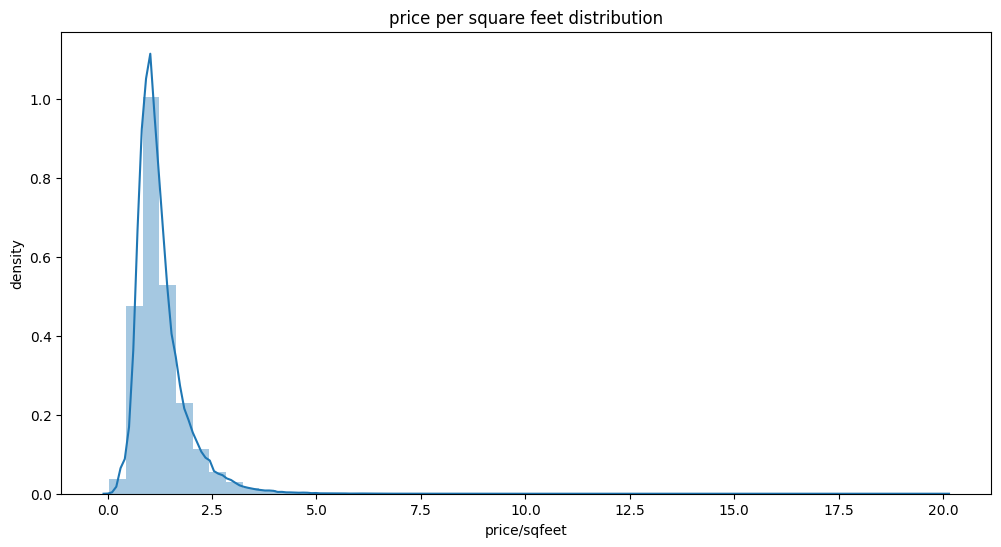

In [124]:
plt.figure(figsize=(12, 6))
sns.distplot(df['price/sqfeet'])
plt.title('price per square feet distribution')
plt.xlabel('price/sqfeet')
plt.ylabel('density')
plt.show()

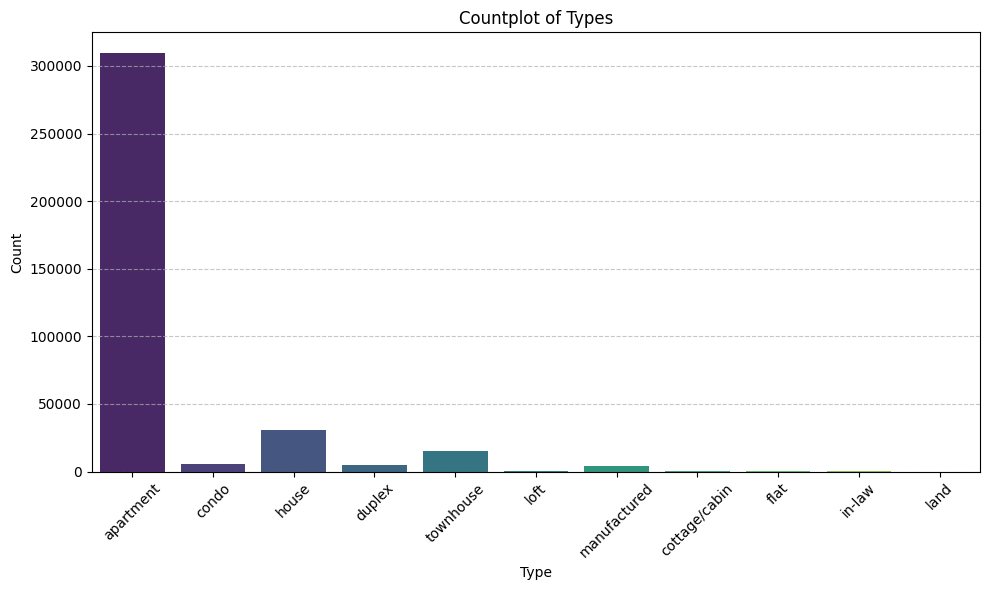

In [133]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', palette='viridis')
plt.title('Countplot of Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

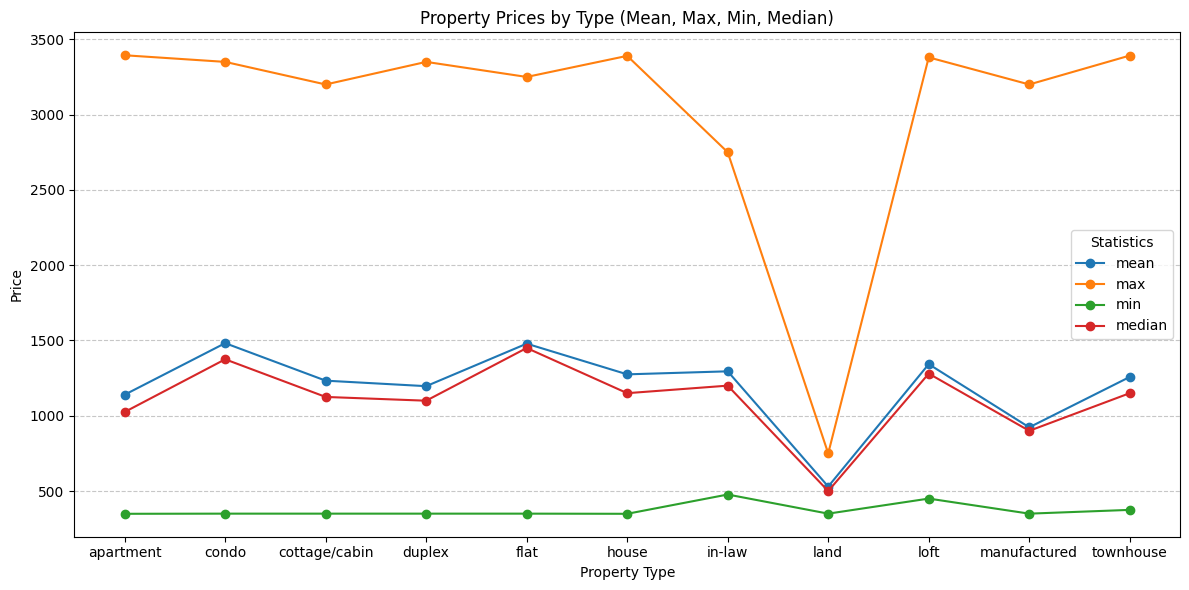

In [134]:
price_by_type = df.groupby('type')['price'].agg(['mean', 'max', 'min', 'median'])

plt.figure(figsize=(12, 6))

for stat in price_by_type.columns:
    plt.plot(price_by_type.index, price_by_type[stat], marker='o', label=stat)

plt.title('Property Prices by Type (Mean, Max, Min, Median)')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Statistics')
plt.tight_layout()
plt.show()

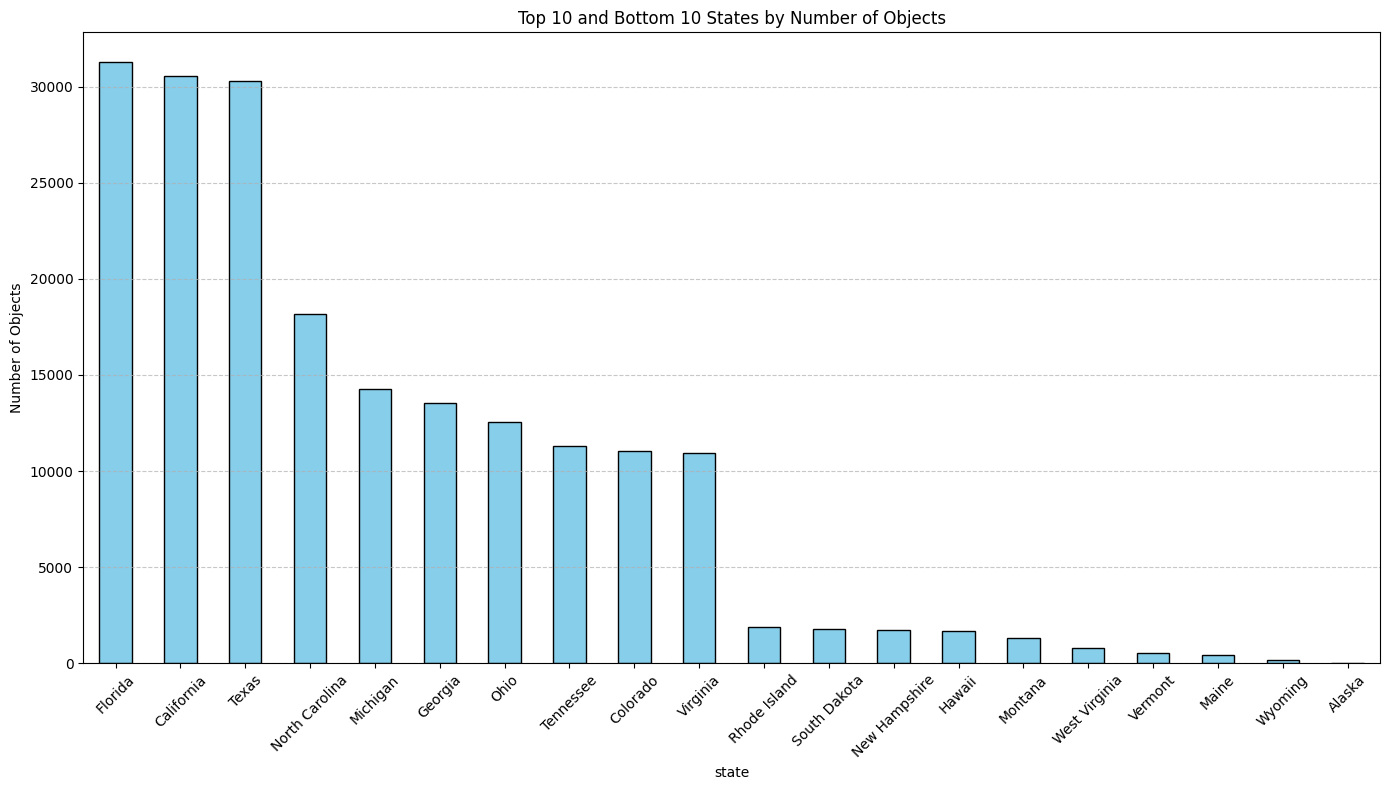

In [135]:
top_10_state_count = df['state_full_name'].value_counts().nlargest(10)
bottom_10_state_count = df['state_full_name'].value_counts().nsmallest(10).sort_values(ascending=False)

combined_state_counts = pd.concat([top_10_state_count, bottom_10_state_count])
categories = ['Top 10'] * len(top_10_state_count) + ['Bottom 10'] * len(bottom_10_state_count)

plt.figure(figsize=(14, 8))
combined_state_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 and Bottom 10 States by Number of Objects')
plt.xlabel('state')
plt.xticks(rotation=45)
plt.ylabel('Number of Objects')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


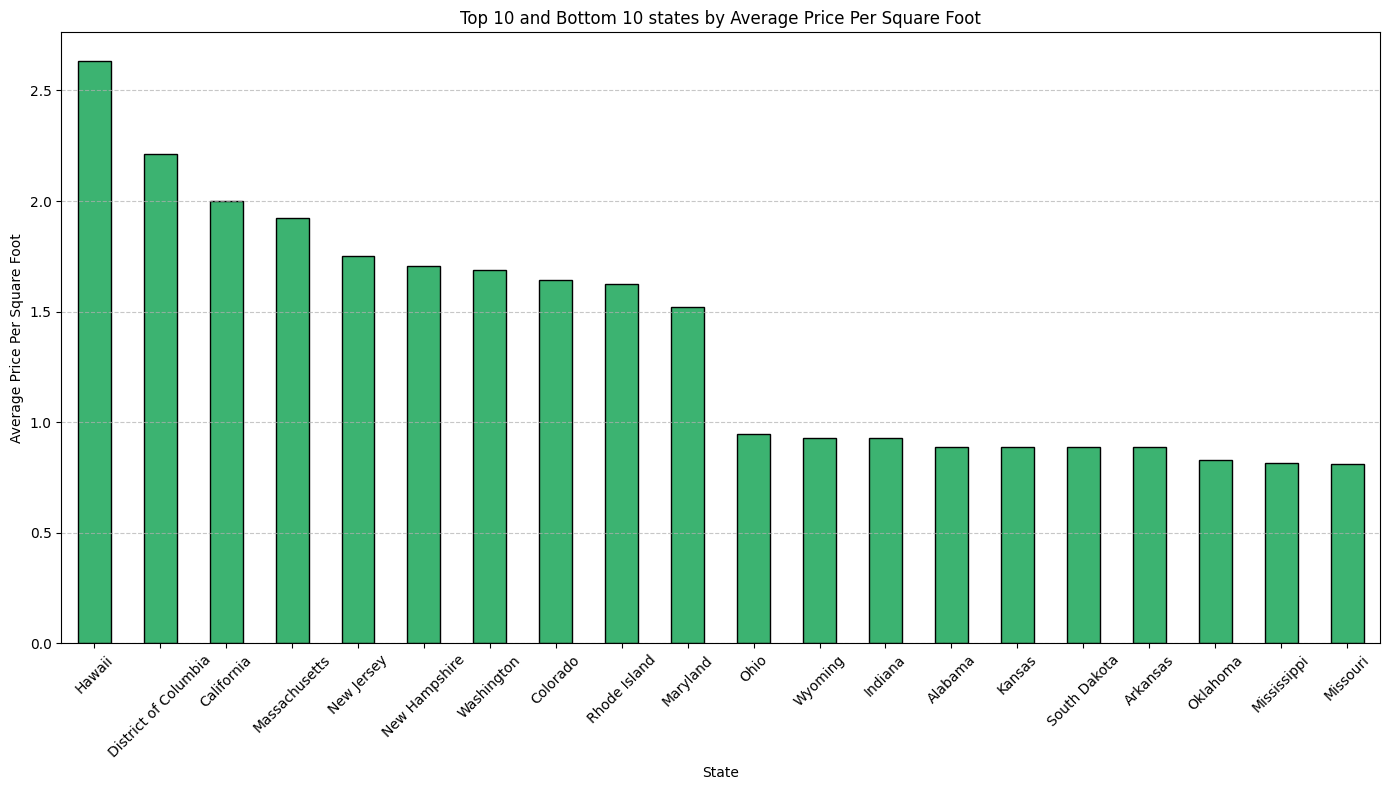

In [136]:
top_10 = df.groupby('state_full_name')['price/sqfeet'].mean().nlargest(10)
bottom_10 = df.groupby('state_full_name')['price/sqfeet'].mean().nsmallest(10).sort_values(ascending=False)

combined = pd.concat([top_10, bottom_10])
categories = ['Top 10'] * len(top_10) + ['Bottom 10'] * len(bottom_10)

plt.figure(figsize=(14, 8))
combined.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Top 10 and Bottom 10 states by Average Price Per Square Foot')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Average Price Per Square Foot')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [167]:
def top_regions_price_per_sqft_by_state(df: pd.DataFrame, state_full_name: str):
    df_sampled = df[df['state_full_name'] == state_full_name]

    top_10 = df_sampled.groupby('region')['price/sqfeet'].mean().nlargest(5)
    bottom_10 = df_sampled.groupby('region')['price/sqfeet'].mean().nsmallest(5).sort_values(ascending=False)

    if len(top_10) < 5:
        combined = top_10
    else:
        combined = pd.concat([top_10, bottom_10])

    plt.figure(figsize=(14, 8))
    combined.plot(kind='bar', color='orange', edgecolor='black')
    plt.title(f'Top 5 and Bottom 5 regions in {state_full_name} by Average Price Per Square Foot')
    plt.xlabel('State')
    plt.xticks(rotation=45)
    plt.ylabel('Average Price Per Square Foot')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

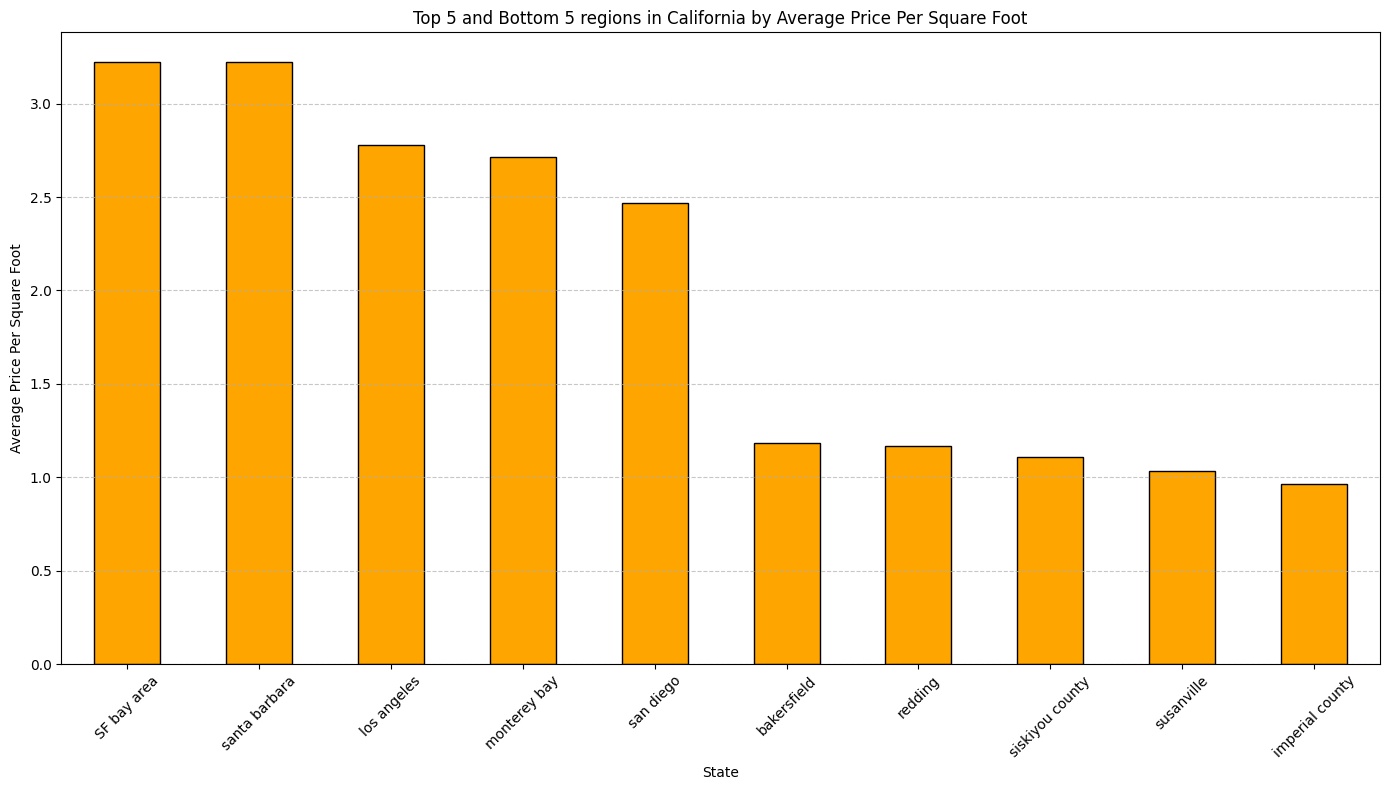

In [168]:
top_regions_price_per_sqft_by_state(df, 'California')

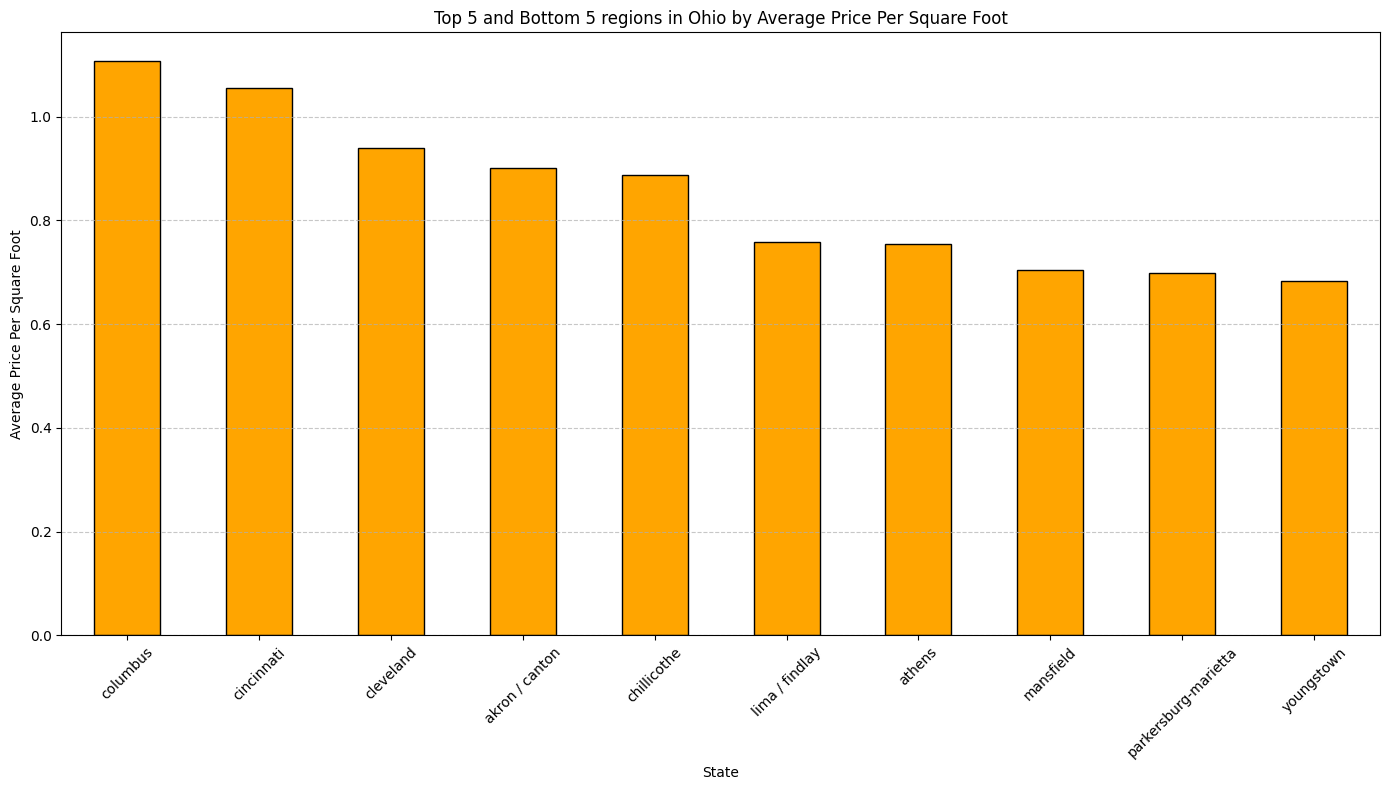

In [169]:
top_regions_price_per_sqft_by_state(df, 'Ohio')

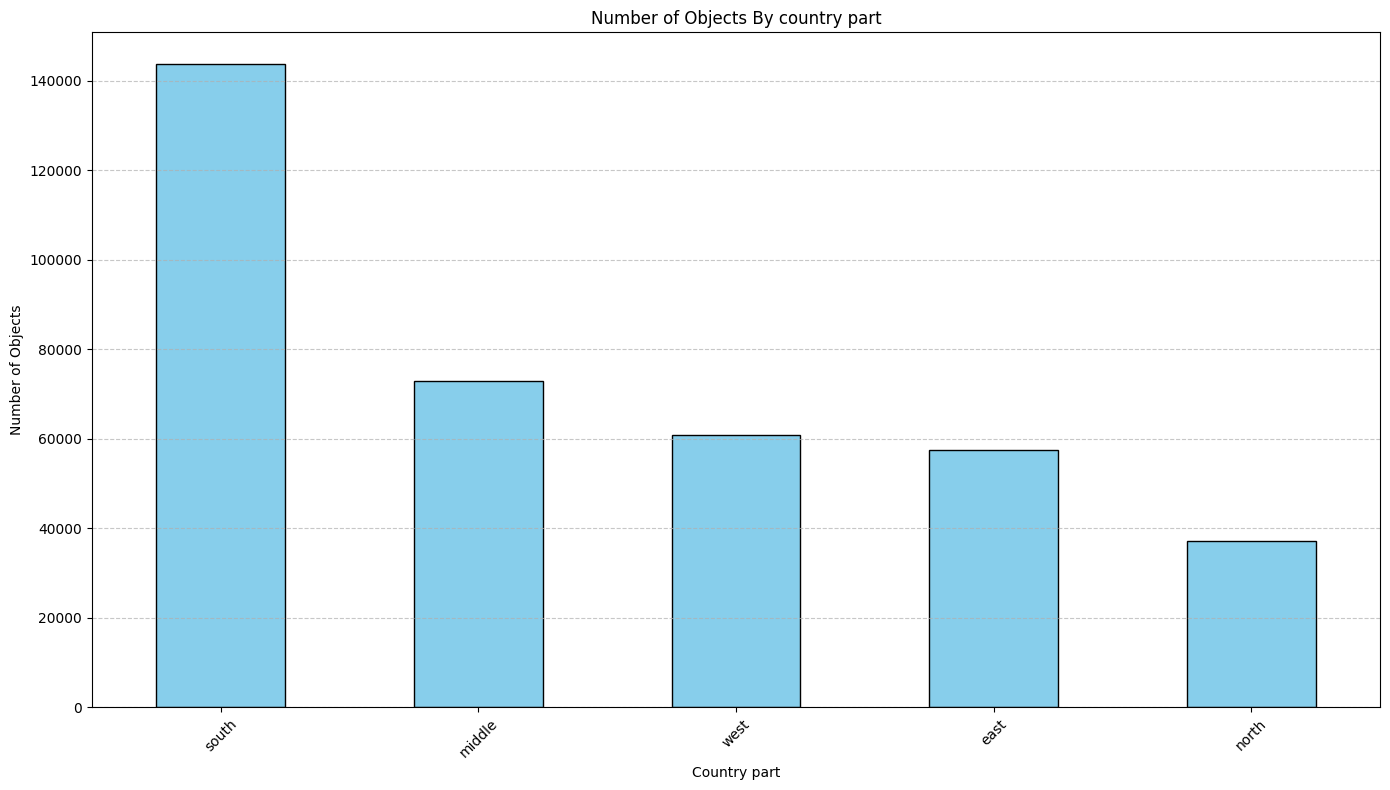

In [137]:
country_part_count = df['country_part'].value_counts()


plt.figure(figsize=(14, 8))
country_part_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Objects By country part')
plt.xlabel('Country part')
plt.xticks(rotation=45)
plt.ylabel('Number of Objects')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


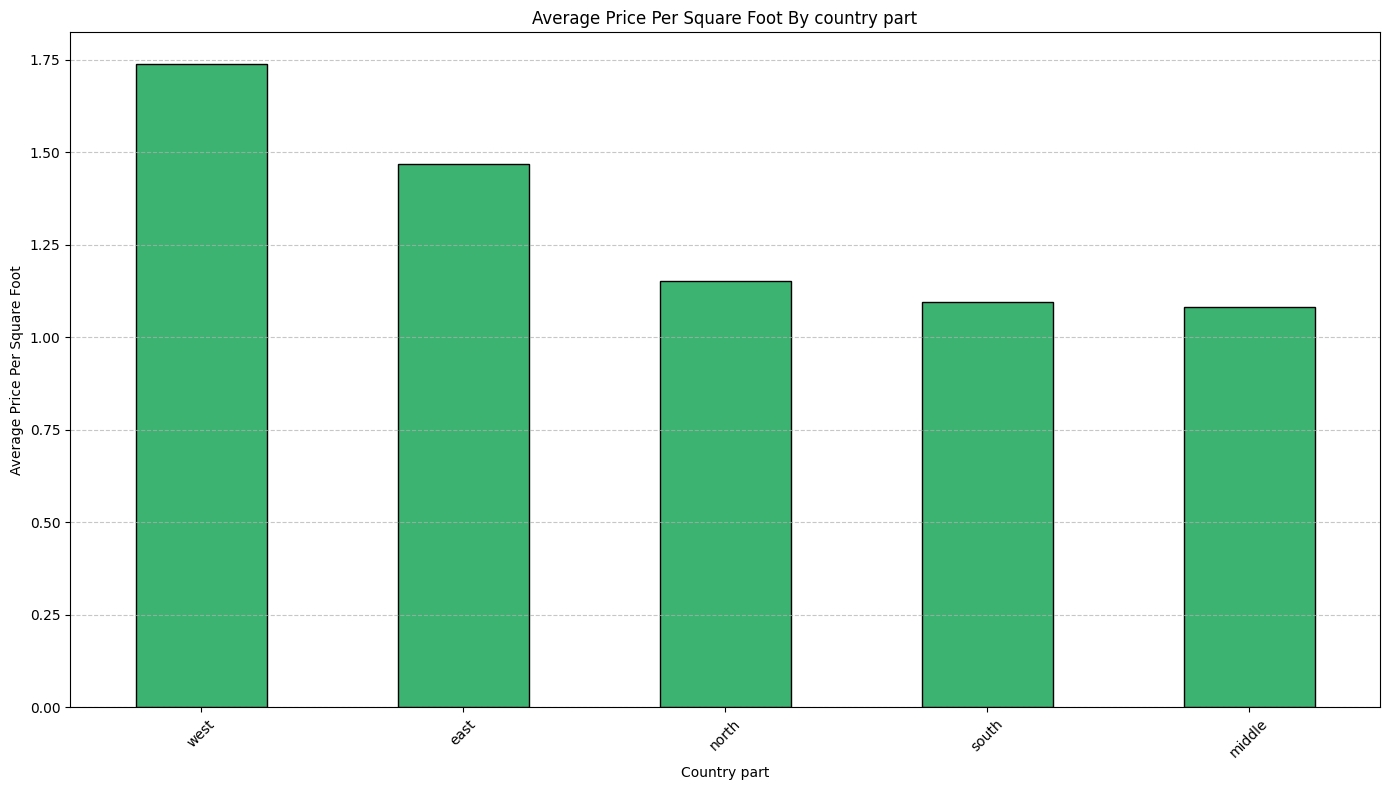

In [138]:
avg_price_per_sqft_country_part = df.groupby('country_part')['price/sqfeet'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
avg_price_per_sqft_country_part.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Average Price Per Square Foot By country part')
plt.xlabel('Country part')
plt.xticks(rotation=45)
plt.ylabel('Average Price Per Square Foot')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [140]:
df.columns

Index(['id', 'region', 'price', 'type', 'sqfeet', 'beds', 'baths',
       'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
       'electric_vehicle_charge', 'comes_furnished', 'laundry_options',
       'parking_options', 'description', 'lat', 'long', 'state',
       'price/sqfeet', 'state_full_name', 'country_part'],
      dtype='object')

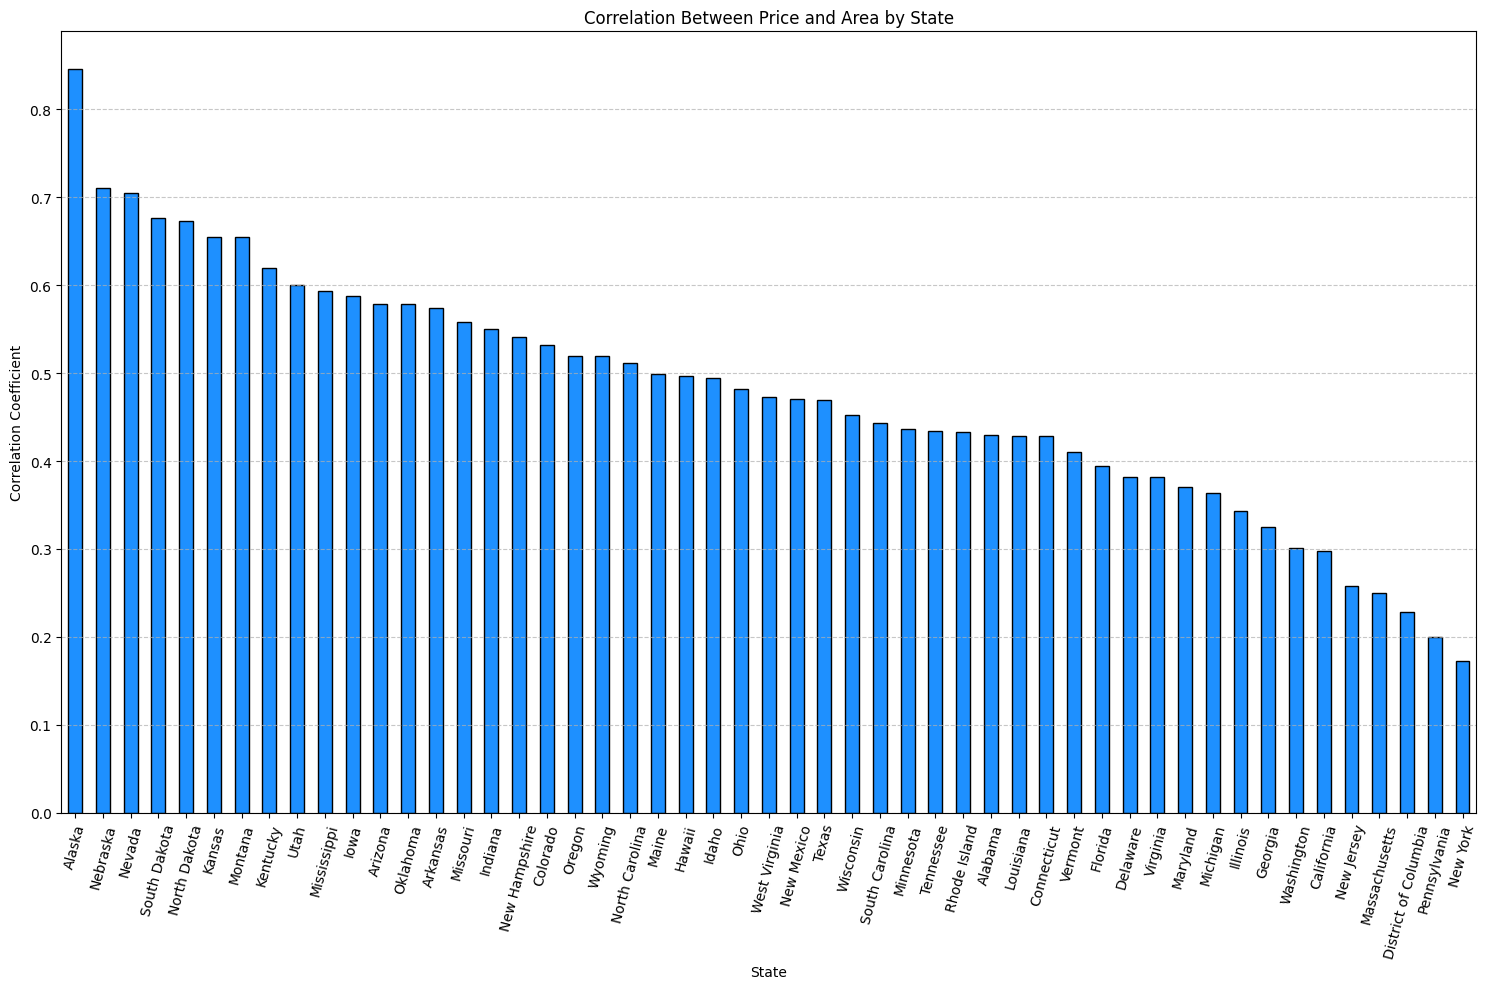

In [148]:
correlations_by_state = df.groupby('state_full_name').apply(lambda group: group['price'].corr(group['sqfeet']))

plt.figure(figsize=(15, 10))
correlations_by_state.sort_values(ascending=False).plot(kind='bar', color='dodgerblue', edgecolor='black')
plt.title('Correlation Between Price and Area by State')
plt.xlabel('State')
plt.xticks(rotation=75)
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()